In [1]:
# # Mount Data folder:

# from google.colab import drive
# drive.mount('/content/drive')

MOVIE = '/home/nghia/Desktop/Lab/MovieRevenuePredicter'

In [2]:
from functions import *

/home/nghia/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
os.listdir()

['obj',
 'chrome_crawler.py',
 'Run_crawl.ipynb',
 'people_feats',
 'exceptions.txt',
 'genre.py',
 'movie.py',
 'Persons',
 'more_people.txt',
 '__pycache__',
 'PersonExceptions.txt',
 'person.py',
 'Person_Crawling.ipynb',
 'Movies',
 'README.md',
 'lib.py',
 '.ipynb_checkpoints',
 '.git',
 'functions.py',
 'Studios',
 'Studio_Crawling.ipynb',
 'xpath.py',
 '.vscode',
 'StudioExceptions.txt',
 'Movies_Preprocess.ipynb']

## 1. Movies

### Load movies data:

In [4]:
movies_dir = MOVIE+'/Movies/'
movies = [movies_dir + movie for movie in os.listdir(movies_dir)]

movies_as_json = []
for movie in movies:
    with open(movie, 'r') as f:
        try:
            movies_as_json.append(json.load(f))
        except:
            continue
        
df = pd.DataFrame(movies_as_json)

### Remove bad rows

In [5]:
# df = pd.DataFrame(movies_as_json)
df = df[df.genre.apply(lambda x: x not in ['Unrated', 'PG-13', 'Not Yet Rated', 'R'])]
df = df[~((df.revenue == '-') & (df.domestic == '-'))]
df.head()

,actor,budget,composer,director,domestic,genre,id,lastseen,mpaa_rating,name,producer,release_date,revenue,runtime,writer
0,[],N/A,-,[],"$12,534,817",Horror,amityville2,-,R,Amityville II:\nThe Possession,[],"September 24, 1982",-,1 hrs. 44 min.,[]
1,[],N/A,-,[https://www.boxofficemojo.com/people/chart/?v...,"$44,722",Drama,warathome,-,R,The War at Home,[],"November 22, 1996",-,1 hrs. 59 min.,[]
2,[],N/A,-,[],"$6,646",Foreign,darkbluealmostblack,-,Unrated,DarkBlueAlmostBlack,[],"October 19, 2007","$2,171,323",1 hrs. 45 min.,[]
3,[],N/A,-,[],"$137,221",Horror Comedy,severance,-,R,Severance,[],"May 18, 2007","$5,515,163",1 hrs. 36 min.,[]
4,[https://www.boxofficemojo.com/people/chart/?v...,N/A,None,[https://www.boxofficemojo.com/people/chart/?v...,"$63,270,710",Comedy,dave,-,PG-13,Dave,[https://www.boxofficemojo.com/people/chart/?v...,"May 7, 1993",-,1 hrs. 50 min.,[https://www.boxofficemojo.com/people/chart/?v...


### Convert string columns to correct data type:

In [6]:
df.budget = df.budget.apply(money_str2float)
df.domestic = df.domestic.apply(money_str2float)
df.revenue = df.revenue.apply(money_str2float)

df.release_date = df.release_date.apply(parse_datetime)
df.runtime = df.runtime.apply(time_str2mins)

for feat in ['actor', 'director', 'producer', 'writer']:
    df[feat] = df[feat].apply(lambda x: [get_id(item) for item in x])

df.composer.fillna('-', inplace=True)
df.composer = df.composer.apply(get_id)

In [7]:
df.revenue = df[['revenue', 'domestic']].apply(lambda x: max(x[1], x[0]), axis=1)
df.drop(['domestic'], axis=1, inplace=True)

In [8]:
for feat in ['revenue', 'budget']:
    df[feat] = df[feat] / 1e6
    
df['budget_available'] = ~df.budget.isnull()
df['budget_available'] = df['budget_available'].astype(np.int8)

df.release_date.fillna(np.datetime64(date(2018,1,1)))
df = df[~df['release_date'].apply(lambda x: '2018-01-01' in str(x))]
df['month'] = df['release_date'].apply(lambda x: int(str(x)[5:7]))

df['season'] = df['month'].apply(get_season)
df['movie_season'] = df['id'].apply(get_movie_season)

for feat in ['actor', 'director', 'producer', 'writer']:
    df['num_'+feat] = df[feat].apply(lambda x: len(x))

In [9]:
df.head()

,actor,budget,composer,director,genre,id,lastseen,mpaa_rating,name,producer,...,runtime,writer,budget_available,month,season,movie_season,num_actor,num_director,num_producer,num_writer
0,[],NaN,-,[],Horror,amityville2,-,R,Amityville II:\nThe Possession,[],...,104.0,[],0,9,3,2,0,0,0,0
1,[],NaN,-,[kathybates],Drama,warathome,-,R,The War at Home,[],...,119.0,[],0,11,3,1,0,1,0,0
2,[],NaN,-,[],Foreign,darkbluealmostblack,-,Unrated,DarkBlueAlmostBlack,[],...,105.0,[],0,10,3,1,0,0,0,0
3,[],NaN,-,[],Horror Comedy,severance,-,R,Severance,[],...,96.0,[],0,5,1,1,0,0,0,0
4,"[kevinkline, sigourneyweaver, franklangella, b...",NaN,-,[ivanreitman],Comedy,dave,-,PG-13,Dave,"[laurenschulerdonner, joemedjuck, ivanreitman]",...,110.0,[garyross],0,5,1,1,5,1,3,1


## 2. Person:

### Load person data:

In [10]:
persons_dir = MOVIE+'/Persons/'
persons = [persons_dir + person for person in os.listdir(persons_dir)]

persons_as_json = []
for person in persons:
    with open(person, 'r') as f:
        try:
            persons_as_json.append(json.load(f))
        except:
            continue
df1 = pd.DataFrame(persons_as_json)

In [11]:
df1 = pd.DataFrame(persons_as_json)
df1.head()

,average,id,movies,name,role
0,"42,450,867",edwardnorton,"[{'date': '3/23/18', 'title': 'isleofdogs', 's...",Edward Norton,Actors
1,"76,459,162",rickygervais,"[{'date': '12/19/14', 'title': 'nightatthemuse...",Ricky Gervais,Actors
2,"24,993,931",naomiwatts,"[{'date': '8/11/17', 'title': 'theglasscastle'...",Naomi Watts,Actors
3,"336,840,977",jjabrams,"[{'date': '12/18/15', 'title': 'starwars7', 's...",J.J. Abrams,Directors
4,"3,614,619",johnsloss,"[{'date': '11/3/17', 'title': 'lastflagflying'...",John Sloss,Producers


### Processing persons data:

In [12]:
df_person = df1[df1.columns]
df_person['studio'] = df_person.movies.apply(lambda x: [movie['studio'] for movie in x])
df_person.movies = df_person.movies.apply(lambda x: [movie['title'] for movie in x])

df_person.average = df_person.average.apply(money_str2float)
df_person.head()

,average,id,movies,name,role,studio
0,42450867.0,edwardnorton,"[isleofdogs, collateralbeauty, sausageparty, b...",Edward Norton,Actors,"[foxsearchlight, wb-newline, sony, foxsearchli..."
1,76459162.0,rickygervais,"[nightatthemuseum3, muppets2, escapefromplanet...",Ricky Gervais,Actors,"[fox, buenavista, weinsteincompany, wdimension..."
2,24993931.0,naomiwatts,"[theglasscastle, thebookofhenry, chuck, aboutr...",Naomi Watts,Actors,"[lionsgate, focus, ifc, weinsteincompany, euro..."
3,336840977.0,jjabrams,"[starwars7, startrek12, super8, startrek11, mi3]",J.J. Abrams,Directors,"[buenavista, paramount, paramount, paramount, ..."
4,3614619.0,johnsloss,"[lastflagflying, boyhood, dealingwithidiots, b...",John Sloss,Producers,"[lionsgate, ifc, ifc, sonyclassics, millennium..."


## 3. Studios:

In [13]:
studios_dir = MOVIE+'/Studios/'
studios = [studios_dir + studio for studio in os.listdir(studios_dir)]

studios_as_json = []
for studio in studios:
    with open(studio, 'r') as f:
        try:
            studios_as_json.append(json.load(f))
        except:
            continue
df_studio = pd.DataFrame(studios_as_json)

df_studio.totals = df_studio.totals.apply(lambda x: float(sub(r'[^\d.]', '', x)))
df_studio.averages = df_studio.averages.apply(lambda x: float(sub(r'[^\d.]', '', x)))

df_studio['num_film'] = df_studio.totals / df_studio.averages
df_studio['num_film'] = df_studio['num_film'].apply(lambda x: int(x+.5))
df_studio.head()

,averages,id,name,totals,num_film
0,149090.0,mmoore,MICHAEL MOORE,149090.0,1
1,34222.0,spitnglue,SPIT N' GLUE,34222.0,1
2,1477083.0,idp,IDP,93056220.0,63
3,114516.0,manray,MAN RAY ASSOC.,114516.0,1
4,473613.0,republic,REPUBLIC,947226.0,2


## EDA:

### Merge above dataFrames together:

In [14]:
info_list = []

df2 = df1[['id', 'movies', 'role']]
for value in df2.values:
    for film in value[1]:
        info_list.append([value[0], film['date'], film['title'], film['studio'], value[-1], value[1]])

In [15]:
df_info = pd.DataFrame(info_list)
df_info.columns = ['person_name', 'date', 'movie', 'studio', 'role', 'movie_list']
df_info = df_info[df_info['date'] != 'N/A']

df_info.head(3)

,person_name,date,movie,studio,role,movie_list
0,edwardnorton,3/23/18,isleofdogs,foxsearchlight,Actors,"[{'date': '3/23/18', 'title': 'isleofdogs', 's..."
1,edwardnorton,12/16/16,collateralbeauty,wb-newline,Actors,"[{'date': '3/23/18', 'title': 'isleofdogs', 's..."
2,edwardnorton,8/12/16,sausageparty,sony,Actors,"[{'date': '3/23/18', 'title': 'isleofdogs', 's..."


In [16]:
# df_info['more_feats'] = df_info.apply(lambda x: get_person_info(x[-1], str2date(x[1])), axis=1)
# df_info.head()

In [17]:
df_metadata = pd.merge(df_info.drop('movie_list', axis=1), df[['id', 'revenue', 'budget', 'name']].rename(columns={'id':'movie'}), how='left', on='movie')
df_metadata.fillna(-1, inplace=True)
df_metadata = df_metadata[df_metadata.revenue > 0]
df_metadata = df_metadata[df_metadata.date != '1/1/00']
df_metadata.date = df_metadata.date.apply(lambda x: str(str2date(x)))
df_metadata = df_metadata.sort_values('date', ascending=True).reset_index(drop=True)
df_metadata['year'] = df_metadata.date.apply(lambda x: x[:4])
df_metadata = df_metadata[df_metadata.year < '2018']
df_metadata.head()

,person_name,date,movie,studio,role,revenue,budget,name,year
0,jacknicholson,1982-01-29,border,universal,Actors,6.118683,-1.0,The Border,1982
1,michaelchapman,1982-02-05,personalbest,warnerbros,Cinematographers,5.672311,-1.0,Personal Best,1982
2,wolfgangpeterson,1982-02-10,dasboot,columbia,Directors,10.915250,-1.0,Das Boot,1982
3,ianbaker,1982-02-19,barbarosa,universal,Cinematographers,1.736123,-1.0,Barbarosa,1982
4,jerrybruckheimer,1982-04-02,catpeople,universal,Producers,7.000000,-1.0,Cat People,1982


#### Top 10 movies by revenue

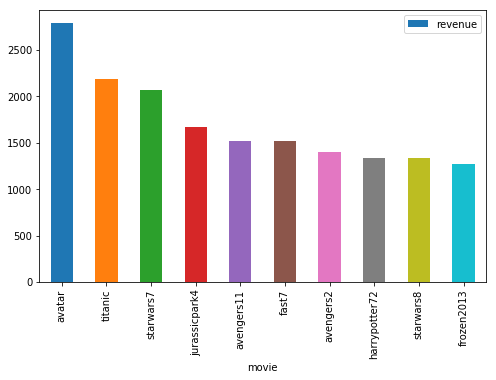

In [18]:
df_metadata[['movie', 'revenue']].drop_duplicates().sort_values('revenue', ascending=False)\
                                 .iloc[:10, :].plot.bar(x='movie', y='revenue', figsize=(8,5))

#### Number of movies per year:

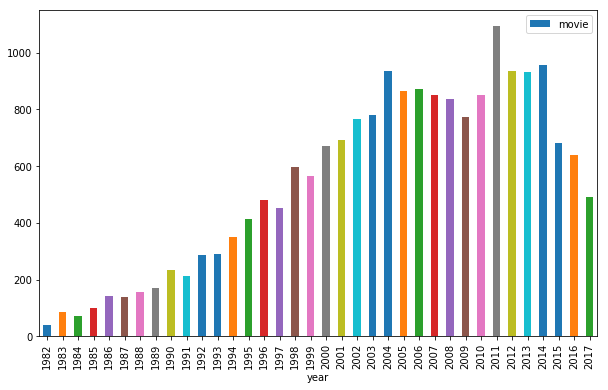

In [19]:
gr_by(df_metadata, value='movie', method='count').plot.bar(x='year', y='movie', figsize=(10,6))
plt.savefig('obj/num_movies.png', dpi=200)

#### Top 20 genre by revenue:

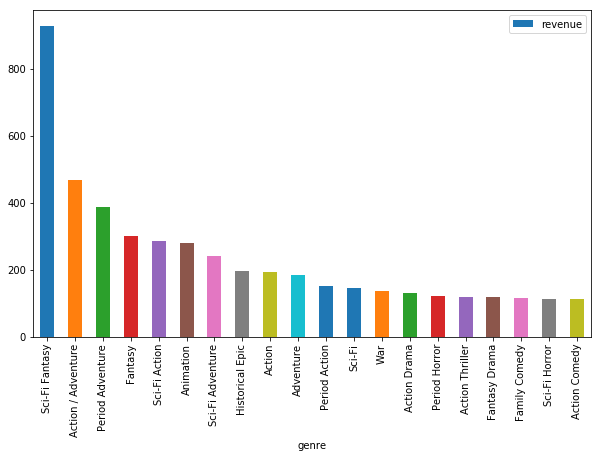

In [20]:
gr_by(df, key='genre').sort_values('revenue', ascending=False).iloc[:20]\
                                                  .plot.bar(x='genre', y='revenue', figsize=(10,6))
plt.savefig('obj/revenue_genres.png', dpi=200)

#### MPAA rating (sorted by avg. revenue): 

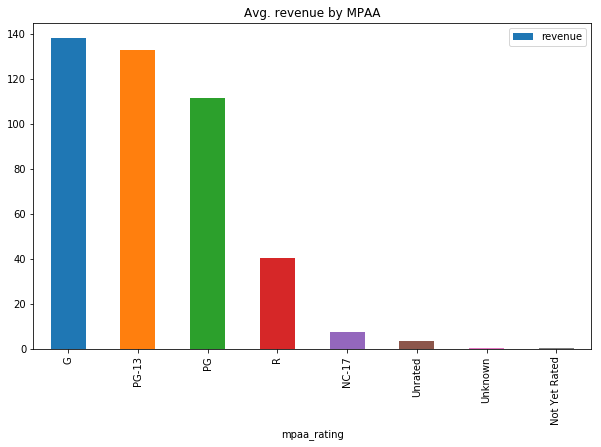

In [21]:
gr_by(df, key='mpaa_rating').sort_values('revenue', ascending=False).iloc[:20]\
                            .plot.bar(x='mpaa_rating', y='revenue', figsize=(10,6), title='Avg. revenue by MPAA')
plt.savefig('obj/revenue_mpaa_rating.png', dpi=200)

#### Revenue by month:

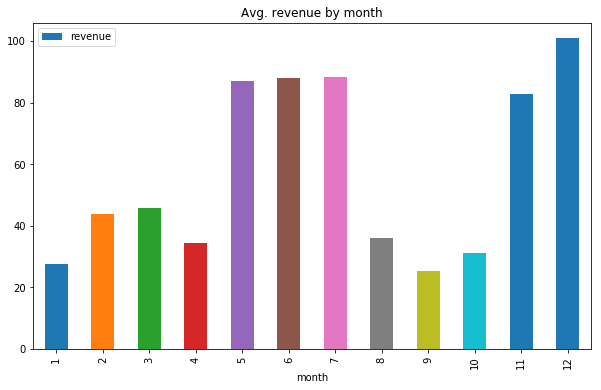

In [22]:
gr_by(df, key='month').plot.bar(x='month', y='revenue', figsize=(10,6), title='Avg. revenue by month')
plt.savefig('obj/revenue_month.png', dpi=200)

#### Revenue by movie season:

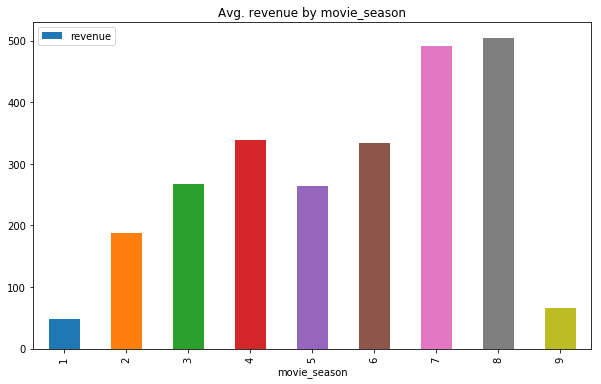

In [23]:
gr_by(df, key='movie_season').plot.bar(x='movie_season', y='revenue', figsize=(10,6), title='Avg. revenue by movie_season')
plt.savefig('obj/revenue_movie_season.png', dpi=200)

#### Compare revenue vs budget of movies:

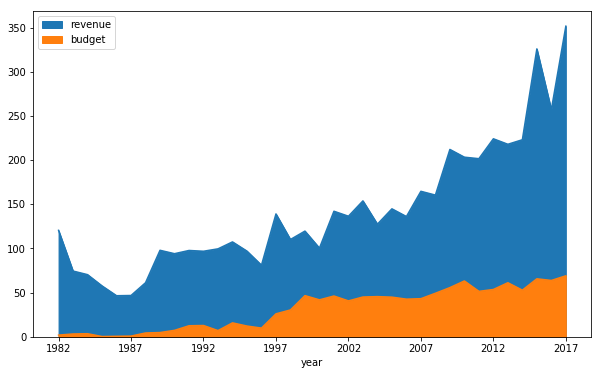

In [24]:
ax = gr_by(df_metadata).plot.area(x='year', y='revenue', figsize=(10,6))
gr_by(df_metadata, value='budget').plot.area(x='year', y='budget', ax=ax)

ax.set_xticklabels([str(year) for year in range(1977, 2018, 5)])

plt.savefig('obj/visual_revenue_vs_budget.png', dpi=200)

#### Top 5 studios by revenue:

In [25]:
df_metadata.groupby('studio').agg({'revenue':'mean', 'name':lambda x: ', '.join(np.unique(x)[-3:])})\
                             .reset_index().sort_values('revenue', ascending=False).reset_index(drop=True)\
                             .rename(columns={'name':'last 3 movies', 'revenue':'avg. revenue'}).head(5)

,studio,avg. revenue,last 3 movies
0,pardw,399.573303,"Transformers: Dark of the Moon, Transformers: ..."
1,buenavista,334.330277,"You Again, Zootopia, crazy/beautiful"
2,summitentertainment,265.212692,"The Twilight Saga:\nEclipse, The Twilight Saga..."
3,wb-newline,252.415275,"Vacation, Valentine's Day, We're the Millers"
4,fox,213.707021,"X2: X-Men United, Young Guns, Young Guns II"


#### Top 5 actors by revenue of movies they joined:

In [26]:
df_metadata.groupby('person_name').agg({'revenue':'mean', 'name':lambda x: ', '.join(np.unique(x)[-3:])})\
                             .reset_index().sort_values('revenue', ascending=False).reset_index(drop=True)\
                             .rename(columns={'name':'last 3 movies', 'revenue':'avg. revenue of movies'}).head(5)

,person_name,avg. revenue of movies,last 3 movies
0,daisyridley,1134.644288,"Star Wars: The Force Awakens, Star Wars: The L..."
1,petermayhew,1130.694856,"Return of the Jedi, Star Wars:\nEpisode III - ..."
2,jonlandau,1078.178937,"Honey, I Shrunk the Kids, Solaris, Titanic"
3,leeunkrich,1066.969703,Toy Story 3
4,treyparker,1034.799409,Despicable Me 3


In [27]:
# gr_by(df, 'genre')

In [28]:
# df.head()

In [29]:
# for i in range(len(person_feats)):
#     df_info[person_feats[i]] = df_info.more_feats.apply(lambda x: x[i])
# df_info.drop(['date', 'movie_list', 'more_feats'], axis=1, inplace=True)
# df.genre = df.genre.apply(lambda x: x[:x.index('-')] if '-' in x else x)
# df_info.head()

In [30]:
# save_obj(df_info, 'obj/people_feats')
# save_obj(df, 'obj/movie_feats')

In [31]:
# from lib import *
# import keras
# from sklearn.preprocessing import LabelEncoder

In [32]:
# df_info = load_obj('obj/people_feats')
# df = load_obj('obj/movie_feats')
# print(df.shape)
# df = df[df['release_date'].apply(lambda x: str(x)[:10] < '2018-06-01')]
# label_encoder = LabelEncoder()
# df.shape

In [33]:
# def get_rank(revenue):
#     if revenue <  1                    : return 0
#     if revenue >= 1   and revenue < 20 : return 1
#     if revenue >= 20  and revenue < 50 : return 2
#     if revenue >= 50  and revenue < 200: return 3
#     if revenue >= 200 and revenue < 500: return 4
#     if revenue >  500                  : return 5
    
# df.revenue = df.revenue.apply(get_rank)
# df.head()

In [34]:
# df.groupby('revenue').count()

In [35]:
# df1 = df[['id', 'lastseen']]
# drop_movies = df[df.id.isin(df1[df1['lastseen'].str.contains('2018')].id.values)].id.values
# df = df[~df.id.isin(drop_movies)]
# df.drop(['lastseen'], axis=1, inplace=True)
# del df1
# gc.collect()

# df1 = df.groupby('genre').agg({'id':'count'}).sort_values('id', ascending=False).reset_index()
# drop_genres = np.append(df1[df1.id < 25].genre.unique(), 'Unknow')
# del df1
# gc.collect()

# df.mpaa_rating = df.mpaa_rating.apply(lambda x: 'Unknown' if x in ['Unrated', 'Not Yet Rated'] else x)

In [36]:
# df.budget = df.budget.fillna(-1)
# df.genre = df.genre.apply(lambda x: 'Others' if x in drop_genres else x)
# available_person_info = df_info.person_name.unique()
# df['composer_available'] = df.composer.apply(lambda x: x in available_person_info).astype(np.int8)
# df.head()

In [37]:
# df1 = df.groupby('genre').agg({'id':'count'}).sort_values('id', ascending=False).reset_index()
# df1['genre_id'] = df1.index
# df = pd.merge(df, df1[['genre', 'genre_id']], on='genre', how='left')
# genre_onehot = keras.utils.to_categorical(df.genre_id.values)
# for i in range(df1.genre.values.shape[0]):
#     df['is_' + df1.genre.values[i]] = genre_onehot[:,i].ravel()
    
# del df1
# gc.collect()


# tmp_mpaa = label_encoder.fit_transform(df.mpaa_rating.values)
# mpaa_onehot = keras.utils.to_categorical(tmp_mpaa)

# for i in range(mpaa_onehot.shape[1]):
#     df['mpaa_' + df.mpaa_rating.unique()[i]] = mpaa_onehot[:,i].ravel()
    
# df.drop(['genre_id'], axis=1, inplace=True)

# df.runtime = df.runtime.fillna(df.runtime.mean())
# df.head()

In [38]:
# df.columns

In [39]:

# from sklearn.model_selection import train_test_split

# incomplete_cols = ['actor', 'director', 'composer', 'genre', 'id', 'mpaa_rating', 'name',\
#                    'producer', 'release_date', 'revenue', 'writer']
# split_day = '2016-06-01'

# df = df.sample(frac=1)

# # df_train = df.iloc[:7000, :] # df[df.release_date.apply(lambda x: str(x)[:10] < split_day)]
# # df_val = df.iloc[7000:, :] # df[df.release_date.apply(lambda x: str(x)[:10] >= split_day)]

# # X_train = df_train.drop(incomplete_cols, axis=1).values
# # y_train = df_train['revenue'].values

# # X_val = df_val.drop(incomplete_cols, axis=1).values
# # y_val = df_val['revenue'].values

# # std_scaler = StandardScaler()
 
# # std_scaler.fit(X_train)
# # X_train = std_scaler.transform(X_train)
# # X_val = std_scaler.transform(X_val)

# X = df.drop(incomplete_cols, axis=1).values
# y = df['revenue'].values

# X_train, X_val, y_train, y_val = train_test_split(X, y)


# y_train = keras.utils.to_categorical(y_train, num_classes=9)
# y_val = keras.utils.to_categorical(y_val, num_classes=9)

# X_train.shape, y_train.shape, X_val.shape, y_val.shape

In [40]:
# keras.__version__

In [41]:
# model = Sequential()
# model.add(Dense(64, activation='relu', input_dim=63))
# model.add(Dropout(0.1))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(9, activation='softmax'))

# optimizer = Adam(lr=0.01, decay=1e-6)
# model.compile(loss='mean_squared_error',
#               optimizer=optimizer)

# model.fit(X_train, y_train, batch_size=16, epochs=20)

In [42]:
# model.summary()

In [43]:
# pred = model.predict(X_val)
# preds = [np.argmax(p) for p in pred]# pred =
# df_pred = pd.DataFrame([preds, y_vals])
# df_pred = df_pred.T
# df_pred.columns = ['actual', 'pred']
# df_pred['count'] = df_pred.actual == df_pred.pred
# # df_pred.groupby(['actual', 'pred']).agg({'count':'sum'}).reset_index()
# y_vals = [np.argmax(p) for p in y_val]

In [44]:
# # pred =
# df_pred = pd.DataFrame([preds, y_vals])
# df_pred = df_pred.T
# df_pred.columns = ['actual', 'pred']
# df_pred['count'] = df_pred.actual == df_pred.pred
# # df_pred.groupby(['actual', 'pred']).agg({'count':'sum'}).reset_index()

In [45]:
# df.groupby('revenue').count()

In [46]:
# df_person[df_person.role.isin(['Actors', 'Directors'])]

In [47]:
# df[df['movie_season']<1][['name', 'id', 'movie_season']]